#  NER Básico
Treinamento de dois modelos Bert para reconhecimento de entidades (NER). Nesse notebook foram estudados os seguintes problemas em tarefas de reconhecimento de entidades:


*   Alinhamento de Labels com os *wordpieces* gerados na tokenização.
*   Preparação dos tokens com anotações em *spans* (inicio e fim de uma entidade no texto).
*   Preparação dos tokens com arquivos tokenizados com a respectiva *tag*.
*   Métricas para avaliação do modelo após treinamento com validação.
*   Construção de classes e funções genéricas para uso em outras atividades de reconhecimento de entidade.



##### Instalação de bibliotecas e Configurações iniciais

In [ ]:
pip install transformers

     |████████████████████████████████| 2.8 MB 7.0 MB/s 
     |████████████████████████████████| 636 kB 69.1 MB/s 
     |████████████████████████████████| 52 kB 2.2 MB/s 
     |████████████████████████████████| 895 kB 63.3 MB/s 
     |████████████████████████████████| 3.3 MB 51.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast, BatchEncoding, PreTrainedTokenizerFast, TrainingArguments, Trainer
from transformers import BertForTokenClassification, DistilBertForTokenClassification
from tokenizers import Encoding

import itertools
from typing import List, Any, Dict, Union, Set
import json
from pprint import pprint
import os
import gc
from dataclasses import dataclass
from tqdm import tqdm
from pathlib import Path
from pathlib import Path
import re

import torch
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Constantes

In [ ]:
FORMATO_NER_IOB: str = 'IOB'
FORMATO_NER_BILOU: str = 'BILOU'
IGNORE_LABEL_MODEL_ID: int=-100
IGNORE_LABEL: str='[IGNORE]'

GDRIVE_PATH:str = '/content/drive/MyDrive'
DATASET_DDI_TRAIN:str = os.path.join(GDRIVE_PATH, 'dataset', 'po-ner', 'ddi_train.json')
DATASET_DDI_TEST:str = os.path.join(GDRIVE_PATH, 'dataset', 'po-ner', 'ddi_test.json')
DATASET_WNUT:str = os.path.join(GDRIVE_PATH, 'dataset', 'po-ner', 'wnut17train.conll')


MODEL_BASE: str = 'distilbert-base-cased'
MODEL_TRAINED_PATH: str = os.path.join(GDRIVE_PATH, 'model', 'PO-NER', 'base-ner')
MODEL_TRAINED_LOG: str = os.path.join(MODEL_TRAINED_PATH, 'trainer.log')
LABEL_OUTPUT_PATH: str = os.path.join(MODEL_TRAINED_PATH, 'labelset.txt') 
MODEL_TRAINED_WNUT_PATH: str = os.path.join(GDRIVE_PATH, 'model', 'PO-NER', 'base-ner-wnut')
MODEL_TRAINED_WNUT_LOG: str = os.path.join(MODEL_TRAINED_WNUT_PATH, 'trainer.log')
LABEL_OUTPUT_WNUT_PATH: str = os.path.join(MODEL_TRAINED_WNUT_PATH, 'labelset.txt') 

PUNCTUATION_LIST = [ ',','.',':',';']

CONTROL_TOKENS = ['[PAD]', '[SEP]', '[CLS]' ]


Carregamento dos tokens com diversas origens e formatos:  
*   Palavra/Label - txt
*   Texto/Span/Label - json

Formato de classificação dos Tokens  
* IOB - (I) Inside (O)utside (B)eginning 
* BILOU - (B)eginning (I)nside (L)ast (O)utside (U)nit

Cada tokenizador BERT vai separar os tokens utilizando worpieces com seu respectivo vocabulário, dessa forma a preparação dos labels para métricas/resultados deverá levar em conta a separação de tokens. Por exemplo ao separa os tokens de Starbucks o tokenizador poderia resultar nos tokens: Star, ##bu, ##cks. O alinhamento dos labels com os tokens gerados pelo tokenizador é tarefa preparatória para o treinamento e também inferência do modelo.

Além do alinhamento também será necessário decidir como será a identificação de cada wordpiece, ou seja, ela deve ser ignorada ou deverá seguir o formato de classificação do token, recebendo I para o formato IOB e I ou L para o formato BILOU.

##### Classes

In [ ]:
@dataclass
class TrainingBatchExample:
    batch_encoding: BatchEncoding
    labels: List[List[int]]

In [ ]:
class NERDataset(torch.utils.data.Dataset):
    def __init__(self, batch: Union[BatchEncoding, TrainingBatchExample], labels: List[List[int]]=None):
        _encodings: BatchEncoding = None
        _labels: List[List[int]] = []

        if isinstance(batch, TrainingBatchExample):
            _encodings = batch.batch_encoding
            _labels = batch.labels
        else:
            _encodings = batch
            _labels = labels

        if ("offset_mapping" in _encodings):
            _encoding.pop("offset_mapping")
        self.encodings = _encodings
        self.labels = _labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
class LabelNER:
    """
        Classe preparada para conter os labels de um treinamento/predição de NER.
        Os labels podem vir sem preparação, ou seja, anotações onde somente o nome do label é informado e não estão presentes os prefixos (IOB ou BILOU).

        load_from_list e load_from_annotations devem ser utilizados no treinamento e o label set deve ser gravado utilizando save().
        No caso de predição ou carga para teste utilizar o load para carregar um label set previamente utilizado.
     
    """

    def __str__(self):
            return f"{len(self.labels_to_id)} labels {str(self.labels_to_id)}"

    def __len__(self):
        return len(self.labels_to_id)

    def __init__(self):
        self.labels_to_id = {}
        self.ids_to_label = {}
        
    def get_label_list(self):
        return self.labels_to_id.keys()

    def get_id_list(self):
        return self.ids_to_label.keys()

    def load_from_complete_list(self, labels: List[str]) -> None:
        '''
            Args: 
                labels(:obj:`List[str]`):
                Lista de labels completa, esperado conter O(utside) e os prefixos de cada entidade.
            
            Carrega a lista de labels "as is" sem tratamento.
        '''
        self.labels_to_id: Dict = {label: id for id, label in enumerate(labels)}
        self.ids_to_label:Dict = {id: label for label, id in self.labels_to_id.items()}
        self._finaliza_carga_labels()

    def load_from_simple_list(self, labels: List[str], ner_label_format: str=FORMATO_NER_IOB) -> None:
        '''
            Args: 
                labels(:obj:`List[str]`):
                    Lista de labels sem prefixo e não contendo o tipo O(utside).
                ner_label_format(:obj:`str`, `optional`, defaults to `"IOB"`):
                    Formato para classificação dos tokens de uma entidade - IOB ou BILOU
            
            Inclui o tipo O(utside) e faz a permutação entre labels e os prefixos do formato informado
        '''
        self.labels_to_id["O"] = 0
        self.ids_to_label[0] = "O"
        num = 0  # in case there are no labels
        prefix_list: str = "BI" if ner_label_format == FORMATO_NER_IOB else "BILU"

        for _num, (label, s) in enumerate(itertools.product(labels, prefix_list)):
            num = _num + 1  # skip 0
            l = f"{s}-{label}"
            self.labels_to_id[l] = num
            self.ids_to_label[num] = l
        
        self._finaliza_carga_labels()

    def load_from_file(self, input_file_path:str) -> None:
        '''
            Args: 
                labelset_file(:obj:`str`):
                    Nome do arquivo contendo a lista de labels previamente gravado. Muito importante ter sido gravado por essa classe ou ter a garantia que o arquivo está com os labels na ordem correta.
            
            Carrega o arquivo com os labels ordenados. O arquivo pode ser construido manualmente, mas deve conter um label por linha, na ordem utilizada para treinar o modelo, já que essa ordem foi criada na 
            extração ou carga dos labels para o treinamento do modelo.
        '''
        with open(input_file_path, 'r' ) as label_file:
            for ind, label in enumerate(label_file):
                label = label.strip('\n')
                self.labels_to_id[label] = ind
                self.ids_to_label[ind] = label

    def _finaliza_carga_labels(self) -> None:
        ''' 
            Adicionar o label de ignorar wordpiece para os casos em que o modelo será treinado nesse formato
        '''
        self.labels_to_id[IGNORE_LABEL] = IGNORE_LABEL_MODEL_ID
        self.ids_to_label[IGNORE_LABEL_MODEL_ID] = IGNORE_LABEL

    def save(self, output_file_path: str):
        with open(output_file_path, 'w' ) as label_file:
            for label in self.labels_to_id:
                label_file.write(label)
                label_file.write('\n')    


    def convert_label_list_to_id_list(self, lista: List[str]) -> List[int]:
        """
            Converte uma lista de labels nos respectivos id`s. Para processamento no modelo essa conversão precisará ser realizada
        """
        return list(map(self.labels_to_id.get, lista))

    def convert_id_list_to_label_list(self, lista: List[int]) -> List[str]:
        """
            Converte uma lista de id`s nos respectivos labels. Para compreensão do resultado retornado pelo modelo essa conversão será necessária.
        """
        return list(map(self.ids_to_label.get, lista))  


##### Funções de Serviço

In [ ]:
def align_tokens(batch_encoding :BatchEncoding, 
                list_annotations: Union[List[List[Dict]],List[List[str]]], 
                is_span_annotations: bool=True, 
                ignore_word_piece: bool = False,
                ner_label_format: str=FORMATO_NER_IOB,
                label_ner: LabelNER=None) -> TrainingBatchExample:

    """

    Alinhamento dos tokens e respectivos labels para tratar a disparidade gerada pelos Tokenizadores Bert quando geram Worpieces.
    As anotações foram criadas levando em conta palavras, mas os tokenizadores incluem partes de palavras (wordpieces), exemplo:
    Starbucks --> Star, ##bu, ##cks. A anotação está mapeada para uma entrada de B-Location, contudo três entradas deverão ser tratadas.

    Args:
        batch_encoding (:obj:`BatchEncoding`):
            Batch encoding previamente tokenizado (input_ids, attention_mask). 
            Contém lista de Encodings, ou seja, cada sentença é um encoding e o BatchEncoding contém todos eles.
            O modelo é preparado para receber esse tipo de dado, por isso sua estrutura será preservada.
        
        is_span_annotations(:obj:`bool`, `optional`, defaults to `True`):
            Informa se a lista de anotações está no formato span ou se cada token já está classificado com seu respectivo label.
            Se for span então o parametro list_annotations será do tipo List[List[Dict]]
            Os spans são entradas com inicio e fim de uma faixa de caracteres onde classificados com a entidadade informada. A classificação nesse caso é somente da entidade, não é esperado prefixo IOB ou BILOU.
                
            Se NÃO for span então o parametro list_annotations será do tipo List[List[int]]
            No caso de tokens já classificados (lista de string) espera-se receber os prefixos IOB ou BILOU.

            Ambos os casos a classificação existente está por token, o alinhamento resolverá o problema de alinhamento token --> wordpiece.

        ignore_word_piece(:obj:`bool`, `optional`, defaults to `False`):
            Informa o que fazer com os tokens wordpiece. Se eles forem ignorados então serão treinados com o label -100 (ignorados), caso contrário serão tratados como tokens normais,
            podendo receber I-<label> ou L-<label> (formato BILOU)

        ner_label_format(:obj:`bool`, `optional`, defaults to `"IOB"`):
            Formato de classificação de labels, espera o formato IOB ou BILOU

        label_ner(:obj:`LabelNER`):
            Objeto da classe LabelNER que contém os labels e seus respectivos id's. Será utilizada para converter os labels de string para seus respectivos identificadores.

        Returns:
            :obj:`TrainingBatchExamples`:
                TrainingBatchExamples contendo o BatchEncoding passado e os labels alinhados

    """

    list_aligned_labels: List[List[int]] = []

    for ind_encoding in range(len(batch_encoding.encodings)):
        encoding: Encoding = batch_encoding[ind_encoding]
        annotations = list_annotations[ind_encoding]

        if is_span_annotations:
            aligned_labels_str: List[str] = align_tokens_from_span_annotations(encoding,
                                                                               annotations,
                                                                               ignore_word_piece,
                                                                               ner_label_format)
        else:
           aligned_labels_str: List[str] = align_tokens_from_token_tags(encoding,
                                                                        annotations,
                                                                        ignore_word_piece)     
           
        list_aligned_labels.append(label_ner.convert_label_list_to_id_list(aligned_labels_str))

    training_batch = TrainingBatchExample(batch_encoding, list_aligned_labels)
    
    return training_batch


In [ ]:
def align_tokens_from_span_annotations(encoding: Encoding, 
                                       annotations: List[Dict],                                     
                                       ignore_word_piece: bool = False,
                                       ner_label_format: str=FORMATO_NER_IOB):
    """

    Construção do array de labels de acordo com as anotações por span, tratando alinhamento de tokens com wordpieces.
    
    Args:
        encoding (:obj:`Encoding`):
            Enconding da sentença previamente tokenizada (input_ids, attention_mask)            
        
        annotations(:obj:`List[Dict]`)
            Lista de spans das entidades, ou seja, cada entrada do dicionário contém o inicio e fim de uma entidade que pode conter uma ou mais palavras.
            A função espera receber anotações com as seguintes entradas:
                - start - inicio do span
                - end - fim do span
                - label - label do span. Não é esperado que o label contenha os prefixos IOB ou BILOU, somente o nome do label.

        ignore_word_piece(:obj:`bool`, `optional`, defaults to `False`):
            Informa o que fazer com os tokens wordpiece. Se eles forem ignorados então serão treinados com o label -100 (ignorados), caso contrário serão tratados como tokens normais,
            podendo receber I-<label> ou L-<label> (formato BILOU)

        ner_label_format(:obj:`bool`, `optional`, defaults to `"IOB"`):
            Formato de classificação de labels, espera o formato IOB ou BILOU

        Returns:
            :obj:`List[str]`:
                labels alinhados com os tokens, ignorando ou incluindo nos wordpieces na classificação (parametro ignore_word_piece).

    """

    
    # Inicialização com BILOU e ajusta caso necessário
    unique_prefix: str='U'
    begin_prefix: str='B'
    inside_prefix: str='I'
    last_prefix: str='L'

    if ner_label_format == FORMATO_NER_IOB:
        unique_prefix = 'B'
        last_prefix = 'I'

    tokens = encoding.tokens
    #print(tokens)
    aligned_labels: List[str] = ["O"] * len(tokens)  # Make a list to store our labels the same length as our tokens
    for anno in annotations:
        annotation_token_ix_set = (set())  # A set that stores the token indices of the annotation
        for char_ix in range(anno["start"], anno["end"]):
            token_ix = encoding.char_to_token(char_ix)
            if token_ix is not None:
                if not tokens[token_ix] in PUNCTUATION_LIST: # alguns datasets incluem caracteres de pontuação na entidade por falha nas anotações
                    annotation_token_ix_set.add(token_ix)

        if len(annotation_token_ix_set) == 1:
            # If there is only one token
            token_ix = annotation_token_ix_set.pop()
            aligned_labels[token_ix] = f"{unique_prefix}-{anno['label']}"

        else:
            last_token_in_anno_ix = len(annotation_token_ix_set) - 1
            for num, token_ix in enumerate(sorted(annotation_token_ix_set)):
                ignorar_token: bool=False

                #tratamento worpiece
                if ignore_word_piece:
                    if token_ix > 1: #[CLS] e o primeiro token não serão wordpieces com certeza e o offets deles compromete a lógica [CLS] (0,0) [1o token] (0,1)
                        offset_ini = encoding.offsets[token_ix][0]
                        offset_end_anterior = encoding.offsets[token_ix-1][1]
                        if offset_ini == offset_end_anterior:
                            ignorar_token = True
                            aligned_labels[token_ix] = IGNORE_LABEL        

                if not ignorar_token:
                    if num == 0:
                        prefix = begin_prefix
                    elif num == last_token_in_anno_ix:
                        prefix = last_prefix
                    else:
                        prefix = inside_prefix
                    aligned_labels[token_ix] = f"{prefix}-{anno['label']}"
    return aligned_labels

In [ ]:
def align_tokens_from_token_tags(encoding: Encoding, tag_list: List[str], ignore_word_piece: bool = False):
    """
        Anotações por tokens são feitas em arquivos já tokenizados, não são strings, são linhas de tokens e classificação. O offset para identificação de wordpiece 
        deve ser tratado diferente das strings com anotações por span. Tokens que possuem o primeiro item do offset > 0 e o segundo item diferente de zero são wordpiece 
        (a segunda parte da crítica seria para o [CLS] ou [SEP]).
        Somente o formato IOB será tratado nessa função de alinhamento.

        Args:
        encoding (:obj:`Encoding`):
            Enconding da sentença previamente tokenizada (input_ids, attention_mask)            
        
        tag_list(:obj:`List[str]`)
            Lista com os labels por token. Não possui o tratamento do worpiece. len(label_list) <= len(enconding.tokens)

        ignore_word_piece(:obj:`bool`, `optional`, defaults to `False`):
            Informa o que fazer com os tokens wordpiece. Se eles forem ignorados então serão treinados com o label -100 (ignorados), caso contrário serão tratados como tokens normais,
            podendo receber I-<label> ou L-<label> (formato BILOU)
        
        Returns:
            :obj:`List[str]`:
                labels alinhados com os tokens, ignorando ou incluindo nos wordpieces na classificação (parametro ignore_word_piece).
    """

    aligned_labels: List[str] = ["O"] * len(encoding.tokens)
    ind_label: int = 0
    last_token_label: str = None

    for ind_token, token_input_id in enumerate(encoding.ids):
        offsets = encoding.offsets
        if ind_token == 0: #ignora o [CLS]
            continue
        if (offsets[ind_token][0] > 0):
            if last_token_label is not None:
                if ignore_word_piece:
                    aligned_labels[ind_token] = IGNORE_LABEL
                else:
                    aligned_labels[ind_token] = last_token_label.replace("B-","I-") 
        else:
            # tratamento dos [PAD]`s que vão além da lista de labels
            label: str = tag_list[ind_label] if ind_label < len(tag_list) else "O"
            aligned_labels[ind_token] = label
            last_token_label = label if label != "O" else None                    
            ind_label = ind_label + 1
    
    return aligned_labels

In [ ]:
# Liberar Recursos da GPU
def destroy_model(model: Union[DistilBertForTokenClassification,BertForTokenClassification]):
    del model
    gc.collect()
    torch.cuda.empty_cache()

def destroy_tokenizer(tokenizer: Union[BertTokenizerFast, DistilBertTokenizerFast]):
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
def prepara_NER_prediction_for_metrics(tokenizer: Union[BertTokenizerFast, DistilBertTokenizerFast], 
                                       batch_encoding: BatchEncoding, 
                                       test_labels: numpy.ndarray, 
                                       pred_labels: numpy.ndarray,
                                       ignorar_wordpiece: bool):
    """
        Ajusta da predição realizada pelo NER para avaliação das métricas, tratando wordpieces caso necessário.
        Os seguintes tokens de controle devem ser ignorados: [PAD], [SEP], [CLS]. Ignorar representa atribuir o valor correto à predição, 
        já que a predição que eventualmente foi predita será ignorada na métrica do teste e no uso ordinário.

        Args:
            tokenizer (:obj:`Union[BertTokenizerFast,DistilBertTokenizerFast]`):
                Tokenizer utiilzado no modelo e que tokenizou o batch_encoding.

            batch_encoding (:obj:`BatchEncoding`):
                Batch enconding das sentenças tokenizadas utilizando o tokenizer passado por parametro. Será usado caso os wordpieces sejam ignorados.
            
            test_labels (:obj:`numpy.ndarray(int)`):
                Array com os valores corretos dos labels.
            
            pred_labels (:obj:`numpy.ndarray(int)`):
                Array com os valores inferido pelo modelo.

            ignorar_wordpiece (:obj:`bool`):
                Caso afirmativo os wordpieces serão ignorados e receberão o valor correto, já que o importante seria sua primeira parte, que identifica o token

            
        Returns:
            :obj:`numpy.ndarray(int)`:
                Vetor de predição preparado para aplicação de métricas.
    """
    control_encodings:BatchEncoding = tokenizer(CONTROL_TOKENS)
    # [CLS] e [SEP] são adicionados pelo tokenizador gerando 3 * numero de tokens de controle, por isso foi gerado um set
    ignored_tokens = set([token_id for control_sent in control_encodings.input_ids for token_id in control_sent])
    
    for ind_encoding in range(len(batch_encoding.encodings)):
        encoding:Encoding = batch_encoding[ind_encoding]
        
        for ind_token,input_id in enumerate(encoding.ids):
            if input_id in ignored_tokens:
                if pred_labels[ind_encoding][ind_token] != test_labels[ind_encoding][ind_token]:
                    #print(input_id,' [', ind_encoding, ',', ind_token, '] -', pred_labels[ind_encoding][ind_token], '--> ', test_labels[ind_encoding][ind_token] )
                    pred_labels[ind_encoding][ind_token] = test_labels[ind_encoding][ind_token]


        if ignorar_wordpiece:
            for ind_token, offset in enumerate(encoding.offsets):
                if ind_token <=1:
                    continue
                offset_ini = encoding.offsets[ind_token][0]
                offset_end_anterior = encoding.offsets[ind_token-1][1]
                if offset_ini == offset_end_anterior:
                    pred_labels[ind_encoding,ind_token] = test_labels[ind_encoding,ind_token]

    return pred_labels

In [ ]:
# Retorna os tensores que estão em uso na memória da GPU

def get_gpu_memory_status():
    total = (torch.cuda.get_device_properties(0).total_memory)/(1024 **2)
    reserved = (torch.cuda.memory_reserved(0))/(1024 **2)
    allocated = (torch.cuda.memory_allocated(0))/(1024 **2)
    return f"Total: {total:.2f} | Reserved: {reserved:.2f} | Allocated: {allocated:.2f}"

def print_gpu_use():
    result = []
    for tracked_object in gc.get_objects():
        if torch.is_tensor(tracked_object):
            shape = tracked_object.shape
            result.append({
                'name': type(tracked_object).__name__,
                '1d': len(shape)==1,
                '2d': len(shape)==2,
                'nrows': shape[0] if (len(shape) > 0) else None,
                'ncols': shape[1] if (len(shape) > 1) else None,
                'gpu': tracked_object.is_cuda,
                'pinned': tracked_object.is_pinned()
            })
        
    d = pd.DataFrame(result)
    d.groupby('name')['gpu', 'pinned', '1d', '2d'].sum()
    print(d)



In [ ]:
def plot_grafico_trainer_loss(trainer_loss: numpy.ndarray, validation_loss: numpy.ndarray):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(trainer_loss[:,0],trainer_loss[:,1] , label="training loss")
    plt.plot(validation_loss[:,0], validation_loss[:,1] , label="validation loss")

    # Label the plot.
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

        
---
       
## 1 -  Treinamento com Anotações

In [ ]:
# carregamento e alteração do campo para ficar similar ao esperado pela função que faz os alinhamentos
label_set: Set[str] = set()
with open(DATASET_DDI_TRAIN) as json_ds_file:
    raw = json.load(json_ds_file)
    for example in raw:
        # our simple implementation expects the label to be called label, so we adjust the original data
        for anno in example["annotations"]:
            anno["label"] = anno["tag"]
            label_set.add(anno["label"])

label_list: List[str] = list(label_set)

In [ ]:
# instancia e carrega os valores para a classe que vai gerenciar os labels e seus id`s
label_ner: LabelNER = LabelNER() 
label_ner.load_from_simple_list(label_list, ner_label_format=FORMATO_NER_IOB)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_BASE) # Load a pre-trained tokenizer
tokenized_batch : BatchEncoding = None


In [ ]:
text_list: List[str] = []
annotations_list: List[List[dict]] = []

for example in raw:
    sentenca = example["content"]
    text_list.append(sentenca)
    annotations_list.append(example["annotations"])

In [ ]:
print(len(text_list))

5806


In [ ]:
# separação em train e validation
train_text_list, val_text_list,train_annotations_list, val_annotations_list = train_test_split(text_list, annotations_list, test_size=0.1, random_state=42)

In [ ]:
train_batch_encoding = tokenizer(train_text_list, max_length=512, padding="max_length", truncation=True)
val_batch_encoding = tokenizer(val_text_list, max_length=512, padding="max_length", truncation=True)

In [ ]:
train_batch_example:TrainingBatchExample = align_tokens(train_batch_encoding, 
                                                        train_annotations_list,                  
                                                        is_span_annotations=True, 
                                                        ignore_word_piece=False, 
                                                        ner_label_format=FORMATO_NER_IOB, 
                                                        label_ner=label_ner)

val_batch_example:TrainingBatchExample = align_tokens(val_batch_encoding, 
                                                    val_annotations_list,
                                                    is_span_annotations=True, 
                                                    ignore_word_piece=False, 
                                                    ner_label_format=FORMATO_NER_IOB, 
                                                    label_ner=label_ner)

In [ ]:
print(train_text_list[766])
print(train_batch_example.batch_encoding.encodings[766].tokens)
print(train_batch_example.batch_encoding.encodings[766].offsets)
print(label_ner.convert_id_list_to_label_list(train_batch_example.labels[766]))

Etonogestrel may interact with the following medications: acetaminophen (Tylenol), antibiotics such as ampicillin and tetracycline, anticonvulsants (Dilantin, Phenobarbital, Tegretol, Trileptal, Topamax, Felbatol), antifungals (Gris-PEG, Nizoral, Sporanox), atorvastatin (Lipitor), clofibrate (Atromid-S), cyclosporine (Neoral, Sandimmune), HIV drugs classified as protease inhibitors (Agenerase, Crixivan, Fortovase, Invirase, Kaletra, Norvir, Viracept), morphine (Astramorph, Kadian, MS Contin), phenylbutazone, prednisolone (Prelone), rifadin (rifampin), St. Johns wort, temazepam, theophylline (Theo-Dur), and vitamin C.
['[CLS]', 'Eton', '##og', '##est', '##rel', 'may', 'interact', 'with', 'the', 'following', 'medications', ':', 'ace', '##tam', '##ino', '##phe', '##n', '(', 'Ty', '##len', '##ol', ')', ',', 'anti', '##biotics', 'such', 'as', 'am', '##pic', '##ill', '##in', 'and', 'te', '##tra', '##cy', '##cline', ',', 'anti', '##con', '##vu', '##ls', '##ants', '(', 'Di', '##lant', '##in', 

In [ ]:
print(train_batch_encoding[766])

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


##### Treino

In [ ]:
train_dataset = NERDataset(train_batch_example)
val_dataset = NERDataset(val_batch_example)

In [ ]:
model = DistilBertForTokenClassification.from_pretrained(MODEL_BASE, num_labels=len(label_ner))

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True

)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 5225
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 981


Step,Training Loss,Validation Loss
50,1.248600,0.854282
100,0.471200,0.250659
150,0.203400,0.188431
200,0.176100,0.172515
250,0.155600,0.147593
300,0.140600,0.136630
350,0.124800,0.145590
400,0.116300,0.124872
450,0.113400,0.126587
500,0.107400,0.132496


***** Running Evaluation *****
  Num examples = 581
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 581
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 581
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-150
Configuration saved in ./results/checkpoint-150/config.json
Model weights saved in ./results/checkpoint-150/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 581
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Runni

TrainOutput(global_step=981, training_loss=0.1798032482100554, metrics={'train_runtime': 575.6306, 'train_samples_per_second': 27.231, 'train_steps_per_second': 1.704, 'total_flos': 2048061403238400.0, 'train_loss': 0.1798032482100554, 'epoch': 3.0})

In [ ]:
trainer.save_model(MODEL_TRAINED_PATH)
label_ner.save(LABEL_OUTPUT_PATH)
# o log é gravado manualmente em arquivo txt. O custo para gravar o loss do treino não era pequeno

In [ ]:
destroy_model(model)
print(get_gpu_memory_status())
destroy_tokenizer(tokenizer)
print(get_gpu_memory_status())

Total: 16280.88 | Reserved: 1072.00 | Allocated: 996.03
Total: 16280.88 | Reserved: 1072.00 | Allocated: 996.03


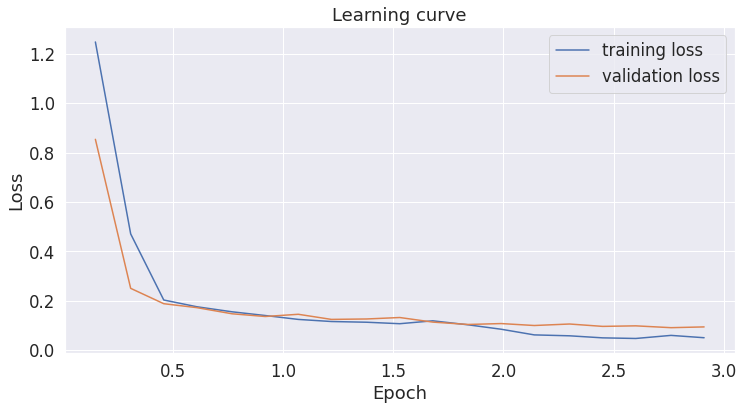

In [ ]:
#grafico sobre train e evaluation loss
df = pd.read_csv(MODEL_TRAINED_LOG,sep='\t')
df['Epoch'] = round((df.Step * training_args.per_device_train_batch_size) / len(train_dataset), 2)
df.tail(10)

train_loss = df[['Epoch', 'Training Loss']].to_numpy()
validation_loss = df[['Epoch', 'Validation Loss']].to_numpy()

plot_grafico_trainer_loss(train_loss, validation_loss)


## 2 - Execução do Modelo para Teste e Métricas (Anotações)

In [ ]:
model = DistilBertForTokenClassification.from_pretrained(MODEL_TRAINED_PATH)
model.to('cuda')

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_BASE) # Load a pre-trained tokenizer

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [ ]:
label_ner = LabelNER()
label_ner.load_from_file(LABEL_OUTPUT_PATH)

In [ ]:
# carrega o arquivo com o dataset de teste
with open(DATASET_DDI_TEST) as json_ds_file:
    raw_test = json.load(json_ds_file)
    for example in raw_test:
        # our simple implementation expects the label to be called label, so we adjust the original data
        for anno in example["annotations"]:
            anno["label"] = anno["tag"]

test_text_list: List[str] = []
test_annotations_list: List[List[dict]] = []

for example in raw_test:
    sentenca = example["content"]
    test_text_list.append(sentenca)
    test_annotations_list.append(example["annotations"])            

In [ ]:
test_batch_encoding:BatchEncoding = tokenizer(test_text_list, 
                                            max_length=512, 
                                            padding="max_length", 
                                            truncation=True,
                                            return_tensors= 'pt')
test_batch_example:TrainingBatchExample = align_tokens(test_batch_encoding, 
                                                        test_annotations_list,                  
                                                        is_span_annotations=True, 
                                                        ignore_word_piece=False, 
                                                        ner_label_format=FORMATO_NER_IOB, 
                                                        label_ner=label_ner)
test_dataset = NERDataset(test_batch_example)

In [ ]:
print(test_batch_encoding.encodings[1].tokens)
print(test_batch_example.labels[2])

['[CLS]', 'H', '##yper', '##tensive', 'c', '##rises', 'have', 'resulted', 'when', 's', '##ym', '##path', '##omi', '##met', '##ic', 'am', '##ines', 'have', 'been', 'used', 'con', '##com', '##ita', '##ntly', 'within', '##14', 'days', 'following', 'use', 'of', 'mon', '##oam', '##ine', 'o', '##xi', '##das', '##e', 'inhibitor', '##s', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [ ]:
# Dataloader para separar o processamento em batchs, não será possível executar a predição em todo dataset de teste de uma vez só
loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
loop = tqdm(loader, leave=True)
final_output_loss = []
final_output_logits = []

for it, batch in enumerate(loop):

    input_ids = batch['input_ids'].to('cuda')
    attention_mask = batch['attention_mask'].to('cuda')
    labels = batch['labels'].to('cuda')

    outputs = model(input_ids=input_ids, 
                    attention_mask=attention_mask, 
                    labels=labels)
    
    final_output_loss.append(outputs.loss.detach().to('cpu').numpy())
    final_output_logits.append(outputs.logits.detach().to('cpu').numpy())


100%|██████████| 97/97 [00:23<00:00,  4.17it/s]


In [ ]:
print (len(final_output_logits))
print (final_output_logits[0].shape)

97
(16, 512, 4)


In [ ]:
test_preds = np.vstack(final_output_logits)
test_preds = np.argmax(test_preds, axis=-1)
test_preds = prepara_NER_prediction_for_metrics(tokenizer=tokenizer, 
                                                batch_encoding=test_dataset.encodings,
                                                test_labels=test_dataset.labels, 
                                                pred_labels=test_preds,
                                                ignorar_wordpiece=False)

In [ ]:
y_true = np.array(test_dataset.labels).ravel()
y_pred = test_preds.ravel()


score = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
print('Weighted - ', score)
score = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
print('Micro - ', score)
score = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print('Macro - ', score)

Weighted -  0.9991854361366738
Micro -  0.9991852461013645
Macro -  0.9854489117390001


In [ ]:
y_true = np.array([[0,2], [1, 2], [0, 1], [2,4]])
y_pred = np.array([[0,2], [1, 2], [0, 3], [2,4]])

y_true = y_true.ravel()
y_pred = y_pred.ravel()

print (y_true)
print (y_pred)

f1_score(y_true, y_pred, average='macro')

[0 2 1 2 0 1 2 4]
[0 2 1 2 0 3 2 4]


0.7333333333333333

In [ ]:
y_true = np.array(test_dataset.labels).ravel()

In [ ]:
print(score)

0.9854489117390001


In [ ]:
type(test_preds)

numpy.ndarray

## 3 - Treinamento com Dataset Tokens/Label

In [ ]:
def read_wnut(file_path):
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)
    token_docs = []
    tag_docs = []
    for doc in raw_docs:
        tokens = []
        tags = []
        for line in doc.split('\n'):
            token, tag = line.split('\t')
            tokens.append(token)
            tags.append(tag)
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

texts, tags = read_wnut(DATASET_WNUT)

In [ ]:
train_text_wnut, val_text_wnut, train_tags_wnut, val_tags_wnut = train_test_split(texts, tags, test_size=.2, random_state=42)

In [ ]:
label_set_wnut = set(np.concatenate([np.array(i) for i in tags]))
label_list_wnut = list(label_set_wnut)
# instancia e carrega os valores para a classe que vai gerenciar os labels e seus id`s
label_ner_wnut: LabelNER = LabelNER() 
label_ner_wnut.load_from_complete_list(label_list_wnut)

In [ ]:
tokenizer_wnut = DistilBertTokenizerFast.from_pretrained(MODEL_BASE) # Load a pre-trained tokenizer
tokenized_batch : BatchEncoding = None

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [ ]:
train_batch_encoding_wnut = tokenizer_wnut(train_text_wnut, is_split_into_words=True, max_length=512, padding="max_length", truncation=True)
val_batch_encoding_wnut = tokenizer_wnut(val_text_wnut, is_split_into_words=True, max_length=512, padding="max_length", truncation=True)

In [ ]:
train_batch_wnut: TrainingBatchExample = align_tokens(train_batch_encoding_wnut, 
                                                        train_tags_wnut,                  
                                                        is_span_annotations=False, 
                                                        ignore_word_piece=False, 
                                                        ner_label_format=FORMATO_NER_IOB, 
                                                        label_ner=label_ner_wnut)

val_batch_wnut: TrainingBatchExample = align_tokens(val_batch_encoding_wnut, 
                                                    val_tags_wnut,
                                                    is_span_annotations=False, 
                                                    ignore_word_piece=False, 
                                                    ner_label_format=FORMATO_NER_IOB, 
                                                    label_ner=label_ner_wnut)

In [ ]:
ind = ind+1
print (train_text_wnut[ind])
print (train_batch_encoding_wnut[ind].tokens)
print (train_batch_encoding_wnut[ind].offsets)
print(label_ner_wnut.convert_id_list_to_label_list(train_batch_wnut.labels[ind]))

['H.E', 'Museveni', 'says', 'we', 'should', 'not', 'plan', 'politics', 'but', 'continue', 'doing', 'our', 'usual', 'activities', '.', 'He', 'wants', 'to', 'adress', 'issues', 'of', 'today', 'not', "tomorrow's."]
['[CLS]', 'H', '.', 'E', 'Muse', '##ven', '##i', 'says', 'we', 'should', 'not', 'plan', 'politics', 'but', 'continue', 'doing', 'our', 'usual', 'activities', '.', 'He', 'wants', 'to', 'ad', '##ress', 'issues', 'of', 'today', 'not', 'tomorrow', "'", 's', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [ ]:
train_dataset_wnut = NERDataset(train_batch_wnut)
val_dataset_wnut = NERDataset(val_batch_wnut)

In [ ]:
model_wnut = DistilBertForTokenClassification.from_pretrained(MODEL_BASE, num_labels=len(label_ner_wnut))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [ ]:
training_args_wnut = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy='steps',
    save_strategy='steps',
    load_best_model_at_end=True

)

In [ ]:
trainer_wnut = Trainer(
    model=model_wnut,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args_wnut,                  # training arguments, defined above
    train_dataset=train_dataset_wnut,         # training dataset
    eval_dataset=val_dataset_wnut             # evaluation dataset
)

In [ ]:
trainer_wnut.train()

***** Running training *****
  Num examples = 2715
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 510


Step,Training Loss,Validation Loss
50,2.332200,1.239032
100,0.428800,0.229955
150,0.243300,0.195053
200,0.193900,0.172566
250,0.175500,0.147836
300,0.151300,0.129161
350,0.126300,0.118958
400,0.092800,0.128491
450,0.099800,0.118197
500,0.102200,0.119451


***** Running Evaluation *****
  Num examples = 679
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 679
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 679
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-150
Configuration saved in ./results/checkpoint-150/config.json
Model weights saved in ./results/checkpoint-150/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 679
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-200
Configuration saved in ./results/checkpoint-200/config.json
Model weights saved in ./results/checkpoint-200/pytorch_model.bin
***** Runni

TrainOutput(global_step=510, training_loss=0.3889874465325299, metrics={'train_runtime': 309.7071, 'train_samples_per_second': 26.299, 'train_steps_per_second': 1.647, 'total_flos': 1064400397608960.0, 'train_loss': 0.3889874465325299, 'epoch': 3.0})

In [ ]:
trainer_wnut.save_model(MODEL_TRAINED_WNUT_PATH)
label_ner_wnut.save(LABEL_OUTPUT_WNUT_PATH)

Saving model checkpoint to /content/drive/MyDrive/model/PO-NER/base-ner-wnut
Configuration saved in /content/drive/MyDrive/model/PO-NER/base-ner-wnut/config.json
Model weights saved in /content/drive/MyDrive/model/PO-NER/base-ner-wnut/pytorch_model.bin


In [ ]:
destroy_model(model_wnut)
print(get_gpu_memory_status())
destroy_tokenizer(tokenizer_wnut)
print(get_gpu_memory_status())

Total: 16280.88 | Reserved: 1072.00 | Allocated: 996.15
Total: 16280.88 | Reserved: 1072.00 | Allocated: 996.15


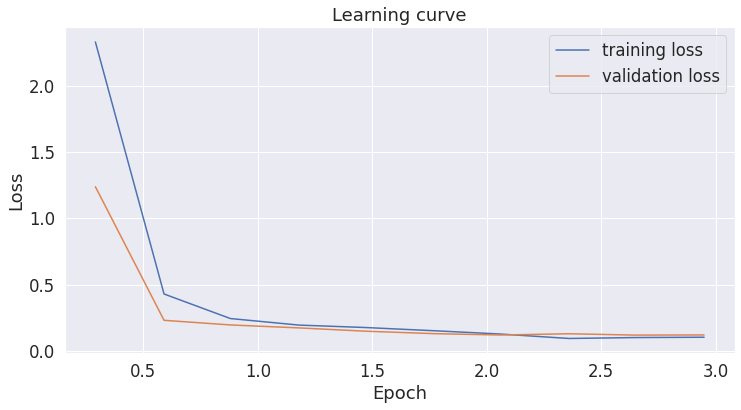

In [ ]:
#grafico sobre train e evaluation loss
df = pd.read_csv(MODEL_TRAINED_WNUT_LOG,sep='\t')
df['Epoch'] = round((df.Step * training_args_wnut.per_device_train_batch_size) / len(train_dataset_wnut), 2)
df.tail(10)

train_loss = df[['Epoch', 'Training Loss']].to_numpy()
validation_loss = df[['Epoch', 'Validation Loss']].to_numpy()

plot_grafico_trainer_loss(train_loss, validation_loss)

#### Validação do alinhamento

In [ ]:
np.array(train_batch_example.batch_encoding.encodings[1].ids)[:60]

array([ 101, 2453, 1336, 2303, 1165, 1175,  112,  188, 1185, 3220, 1107,
       1441,  119,  199, 1613, 7647,  108, 1535,  102,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0])

In [ ]:
np.array(train_text_list[1])

array(['Women', 'may', 'fall', 'when', 'there', "'s", 'no', 'strength',
       'in', 'men', '.', '~William', 'Shakespeare', '#women'],
      dtype='<U11')

In [ ]:
np.array(train_tags_list[1])

array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-person',
       'I-person', 'O'], dtype='<U8')

In [ ]:
np.array(label_ner.convert_id_list_to_label_list(train_batch_example.labels[1]))[:60]

array(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'B-person', 'I-person', 'I-person', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
      dtype='<U8')

In [ ]:
np.array(train_batch_example.batch_encoding.encodings[1].tokens)[:60]

array(['[CLS]', 'Women', 'may', 'fall', 'when', 'there', "'", 's', 'no',
       'strength', 'in', 'men', '.', '~', 'William', 'Shakespeare', '#',
       'women', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',
       '[PAD]'], dtype='<U11')

In [ ]:
indice_analisado = 7
tokens = train_batch_example.batch_encoding.encodings[indice_analisado].tokens
labels = label_ner.convert_id_list_to_label_list(train_batch_example.labels[indice_analisado])
lista = []
is_pad = False
cont = 0
while not is_pad or cont >= len(tokens):
    if tokens[cont] != '[PAD]':
        lista.append([tokens[cont], labels[cont]]) 
    else:
        is_pad = True
    cont+=1

In [ ]:
np.array(lista)